In [1]:
import pandas as pd
import numpy as np

In [17]:
df = pd.read_parquet("data.parquet")
print(df.head())

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27


In [2]:
df = pd.read_parquet("data_cleaned.parquet")
print(df.head())

                     banknifty     nifty  tte
time                                         
2021-01-01 09:15:00   0.286058  0.199729   27
2021-01-01 09:16:00   0.285381  0.200433   27
2021-01-01 09:17:00   0.284233  0.200004   27
2021-01-01 09:18:00   0.286104  0.199860   27
2021-01-01 09:19:00   0.285539  0.198951   27


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 687013 entries, 2021-01-01 09:15:00 to 2022-06-30 15:30:00
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   banknifty  687013 non-null  float64
 1   nifty      687013 non-null  float64
 2   tte        687013 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 18.3 MB
None


In [4]:
print(df.describe())

           banknifty          nifty            tte
count  687013.000000  687013.000000  687013.000000
mean        0.250154       0.179344      15.672436
std         0.057699       0.046139       8.664269
min         0.152732       0.089355       2.000000
25%         0.205307       0.140375       8.000000
50%         0.243977       0.181210      15.000000
75%         0.295293       0.215631      23.000000
max         0.460619       0.306952      31.000000


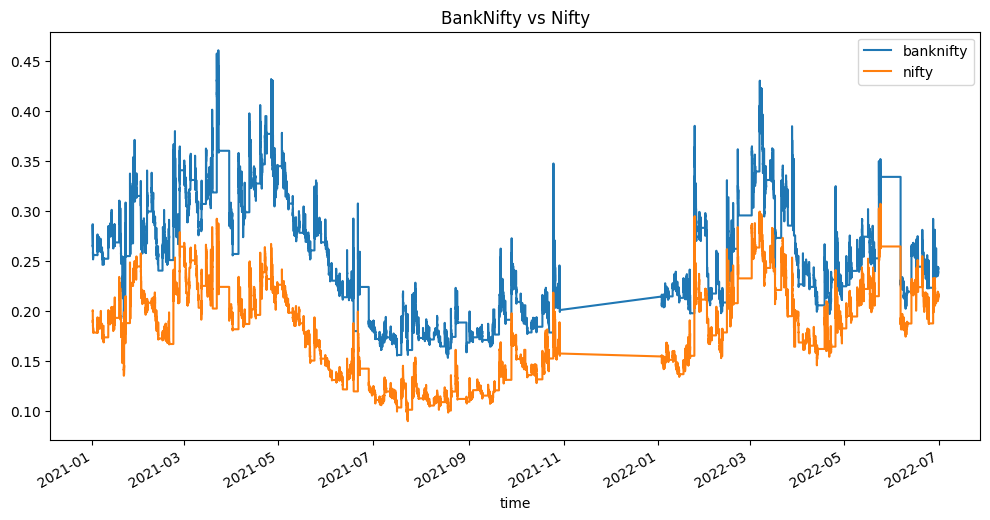

In [5]:
import matplotlib.pyplot as plt

# Plot raw banknifty vs nifty
df[['banknifty', 'nifty']].plot(figsize=(12,6), title="BankNifty vs Nifty")
plt.show()


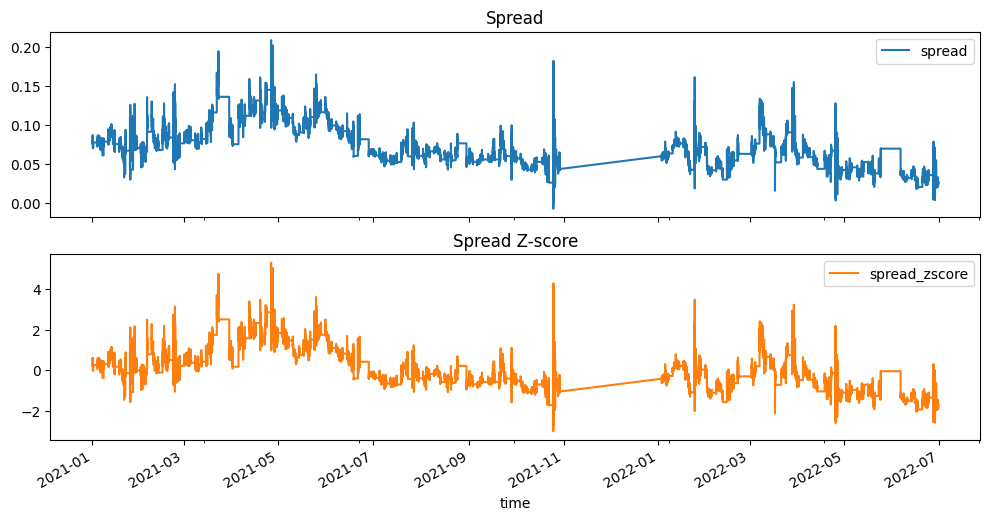

In [6]:
# Spread
df['spread'] = df['banknifty'] - df['nifty']

# Z-score of spread
df['spread_zscore'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()

# Plot spread and z-score
df[['spread','spread_zscore']].plot(figsize=(12,6), subplots=True, title=["Spread","Spread Z-score"])
plt.show()


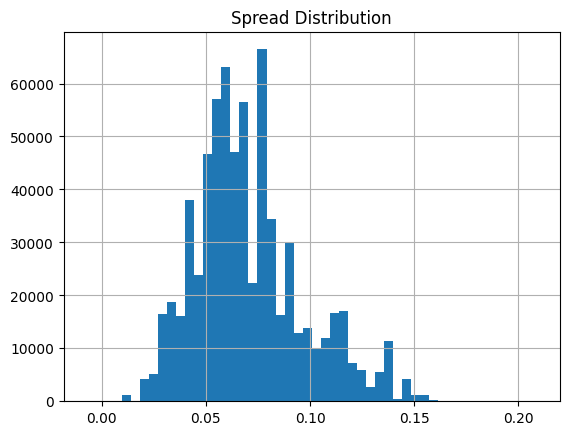

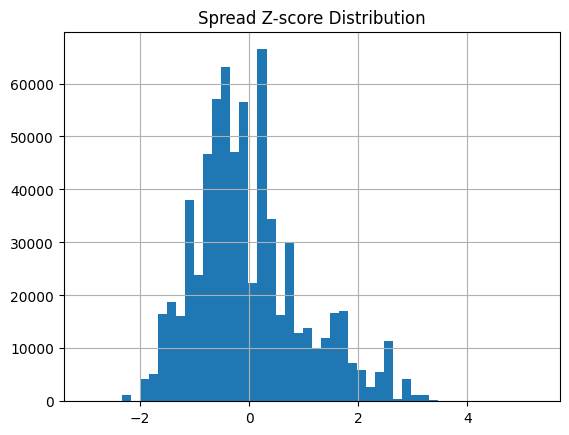

In [7]:
df['spread'].hist(bins=50)
plt.title("Spread Distribution")
plt.show()

df['spread_zscore'].hist(bins=50)
plt.title("Spread Z-score Distribution")
plt.show()

In [8]:
print(df[['banknifty','nifty','spread','spread_zscore','tte']].corr())


               banknifty     nifty    spread  spread_zscore       tte
banknifty       1.000000  0.896274  0.624149       0.624149 -0.069655
nifty           0.896274  1.000000  0.212899       0.212899 -0.055691
spread          0.624149  0.212899  1.000000       1.000000 -0.055346
spread_zscore   0.624149  0.212899  1.000000       1.000000 -0.055346
tte            -0.069655 -0.055691 -0.055346      -0.055346  1.000000


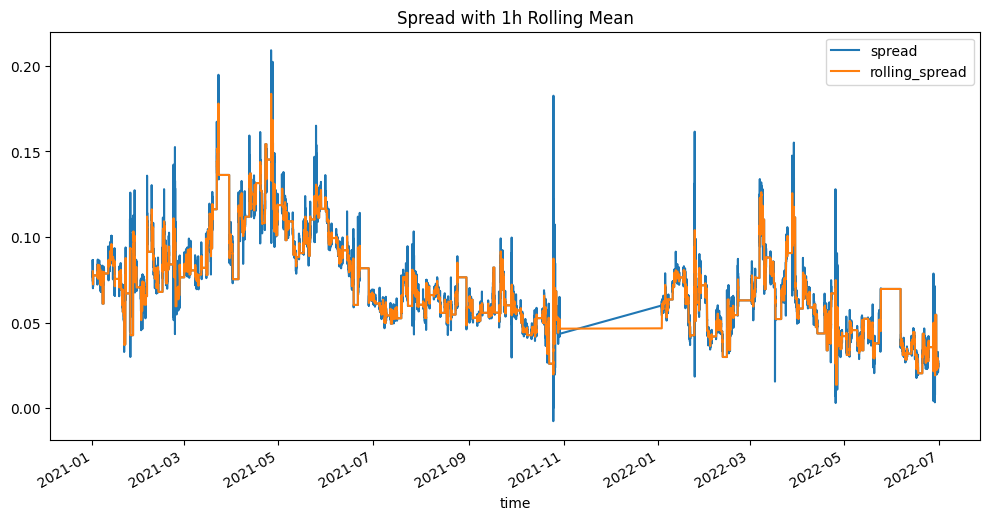

In [9]:
window = 60  # 1 hour
df['rolling_spread'] = df['spread'].rolling(window).mean()

df[['spread', 'rolling_spread']].plot(figsize=(12,6), title="Spread with 1h Rolling Mean")
plt.show()

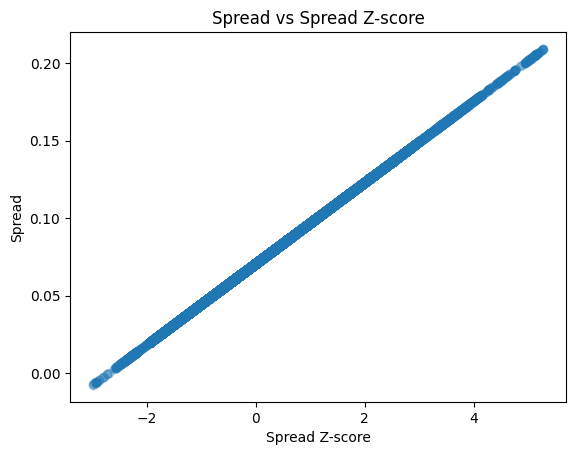

In [10]:
plt.scatter(df['spread_zscore'], df['spread'], alpha=0.3)
plt.xlabel("Spread Z-score")
plt.ylabel("Spread")
plt.title("Spread vs Spread Z-score")
plt.show()

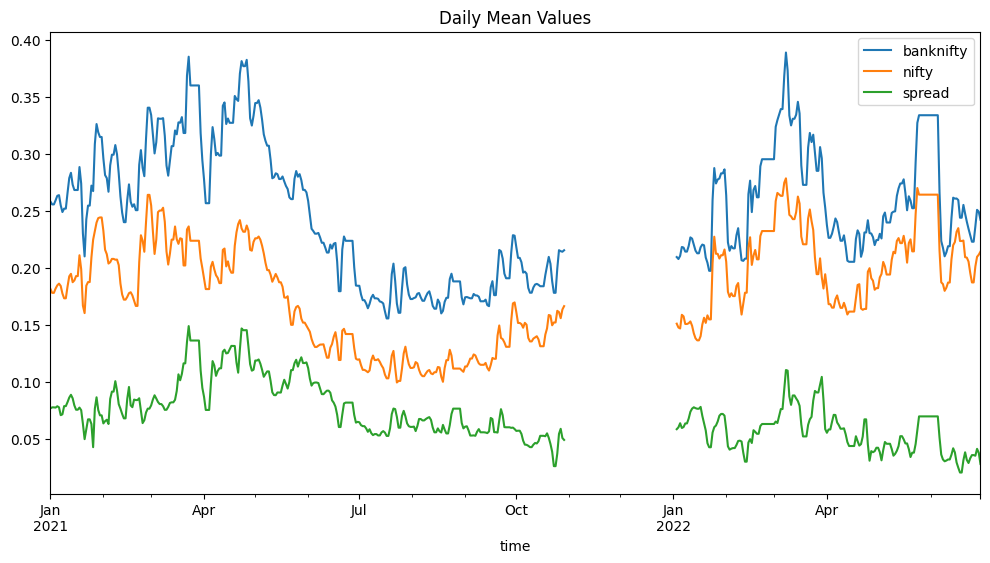

In [11]:
# Daily mean values
daily = df.resample("1D").mean()

daily[['banknifty','nifty','spread']].plot(figsize=(12,6), title="Daily Mean Values")
plt.show()


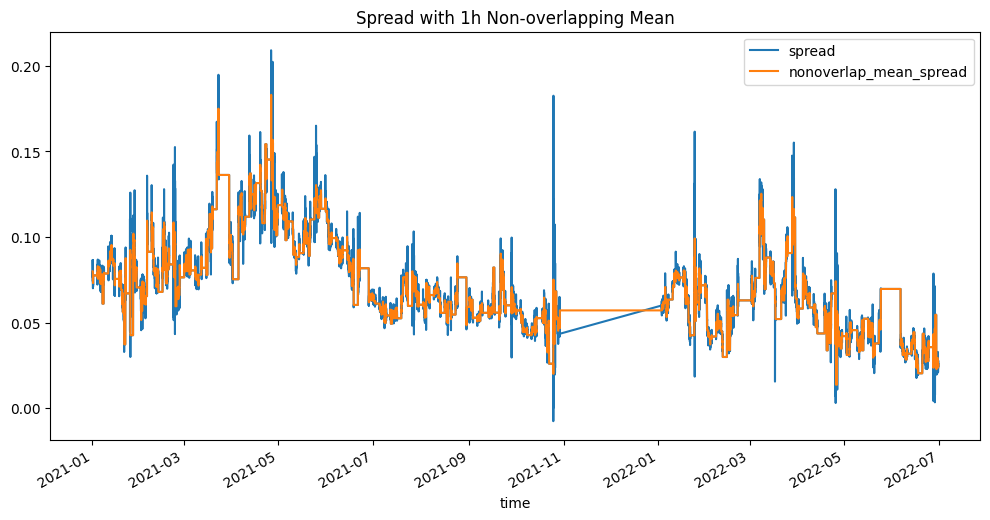

In [12]:
window = 60  # 1 hour = 60 minutes
# Create block indices (0,0,...59 -> 0, then 60,61,...119 -> 1, etc.)
block = np.arange(len(df)) // window  

df['nonoverlap_mean_spread'] = df.groupby(block)['spread'].transform('mean')

df[['spread','nonoverlap_mean_spread']].plot(figsize=(12,6), title="Spread with 1h Non-overlapping Mean")
plt.show()


/tmp/ipykernel_19749/2816261407.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df['spread'].resample("1H").mean()


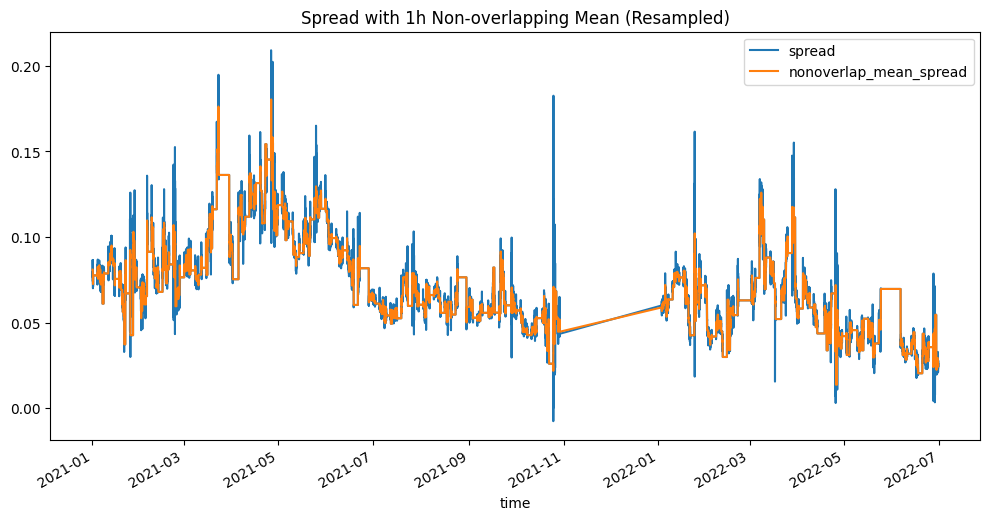

In [13]:
# Compute 1-hour averages
hourly = df['spread'].resample("1H").mean()

# Merge back into original dataframe
df['nonoverlap_mean_spread'] = hourly.reindex(df.index, method='ffill')

df[['spread','nonoverlap_mean_spread']].plot(figsize=(12,6), title="Spread with 1h Non-overlapping Mean (Resampled)")
plt.show()

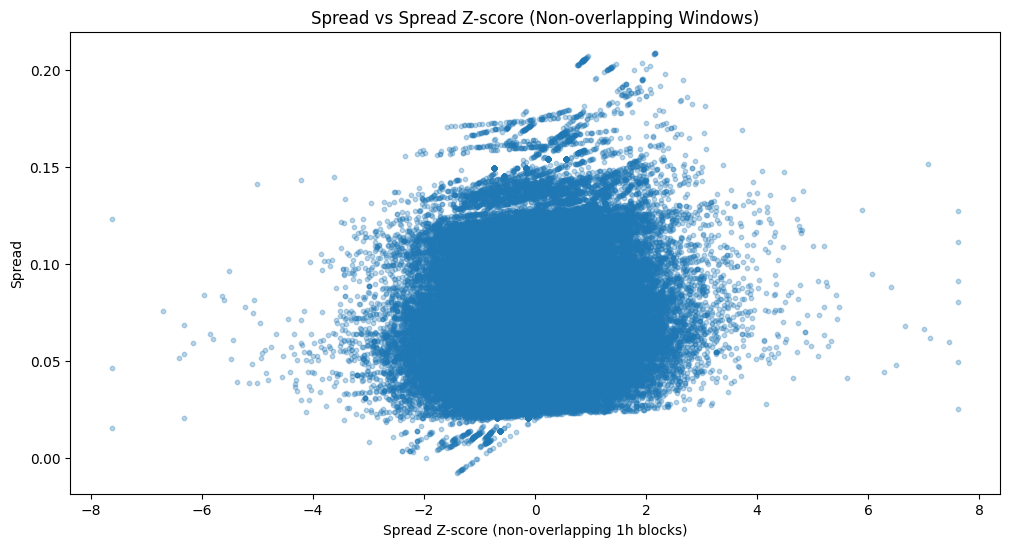

In [14]:
window = 60  # 1 hour (60 minutes)

# assign block index: 0 for first 60 rows, 1 for next 60, etc.
block = np.arange(len(df)) // window

# compute block-level mean & std of spread
block_mean = df.groupby(block)['spread'].transform('mean')
block_std  = df.groupby(block)['spread'].transform('std')

# z-score within each block
df['spread_nonoverlap_mean'] = block_mean
df['spread_nonoverlap_z'] = (df['spread'] - block_mean) / block_std

# --- Plot ---
plt.figure(figsize=(12,6))
plt.scatter(df['spread_nonoverlap_z'], df['spread'], alpha=0.3, s=10)
plt.xlabel("Spread Z-score (non-overlapping 1h blocks)")
plt.ylabel("Spread")
plt.title("Spread vs Spread Z-score (Non-overlapping Windows)")
plt.show()

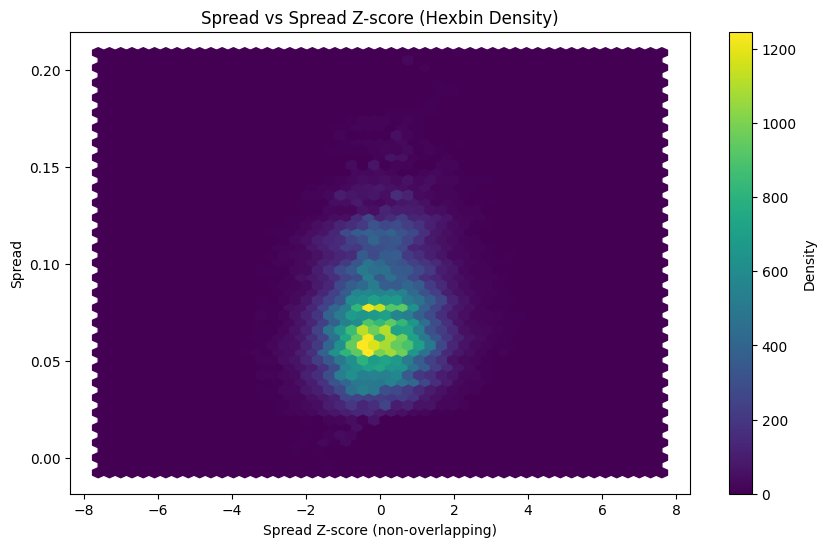

In [15]:
plt.figure(figsize=(10,6))
plt.hexbin(df['spread_nonoverlap_z'], df['spread'], gridsize=50, cmap='viridis')
plt.colorbar(label="Density")
plt.xlabel("Spread Z-score (non-overlapping)")
plt.ylabel("Spread")
plt.title("Spread vs Spread Z-score (Hexbin Density)")
plt.show()


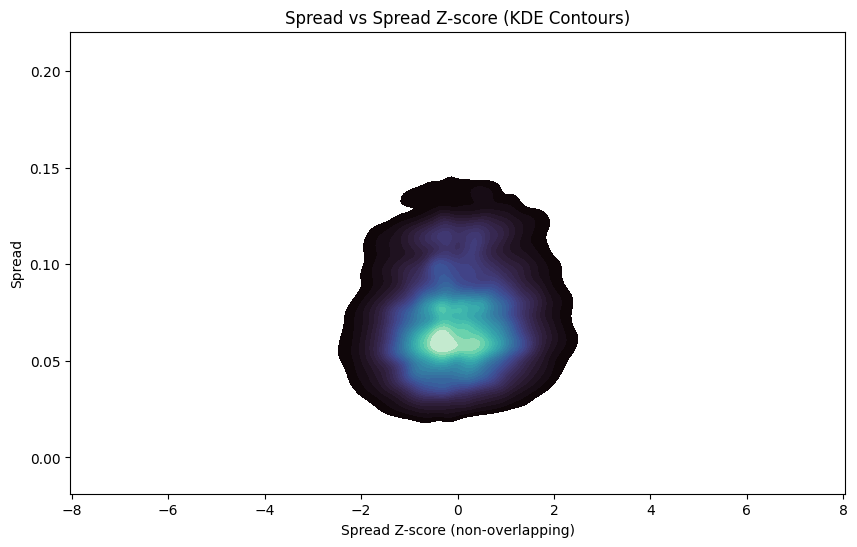

In [16]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.kdeplot(
    x=df['spread_nonoverlap_z'],
    y=df['spread'],
    fill=True, levels=30, cmap="mako"
)
plt.xlabel("Spread Z-score (non-overlapping)")
plt.ylabel("Spread")
plt.title("Spread vs Spread Z-score (KDE Contours)")
plt.show()